In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
# load shots_data.csv
df_shots = pd.read_csv('shots_data.csv')

In [65]:
# train test split
from sklearn.model_selection import train_test_split

X = df_shots[['shotDistance', 'shotAngle', 'shooterPosition', 'clockValue']]
# use pd.get_dummies to convert shooterPosition to one-hot encoding
X = pd.get_dummies(X, columns=['shooterPosition'], dtype=int)
y = df_shots['isGoal']

from sklearn.preprocessing import StandardScaler    
scaler = StandardScaler()
X[['shotDistance', 'shotAngle', 'clockValue']] = scaler.fit_transform(X[['shotDistance', 'shotAngle', 'clockValue']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25168, 7) (6292, 7) (25168,) (6292,)


In [66]:
# test accuracy and calibration
from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.calibration import calibration_curve
def plot_calibration_curve(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    brier = brier_score_loss(y_test, clf.predict_proba(X_test)[:, 1])
    print(f'Brier = {brier}')

    # plot calibration curve
    prob_pos = clf.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Classifier')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid()
    plt.show()

Accuracy: 0.89
Brier = 0.08941278475266519


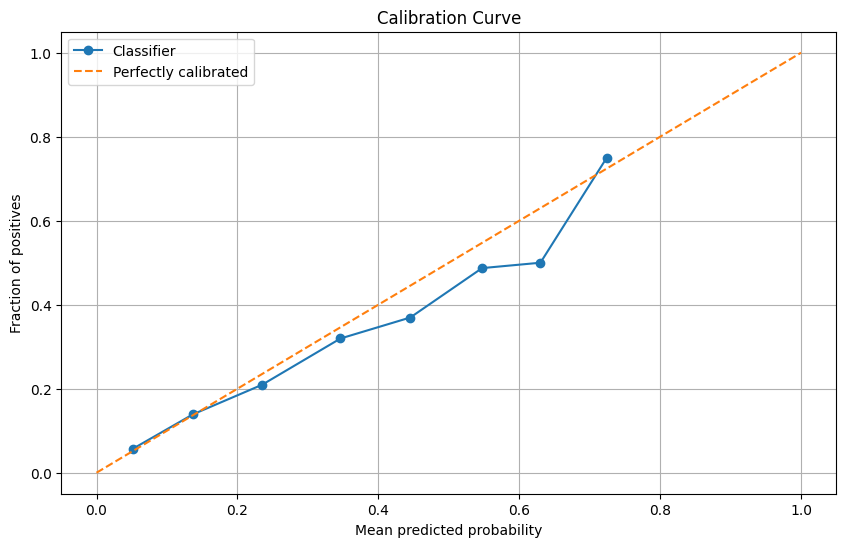

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
# fit calibrated classifier
clf = CalibratedClassifierCV(estimator=GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=6), method='sigmoid')
clf.fit(X_train, y_train)
plot_calibration_curve(clf, X_test, y_test)

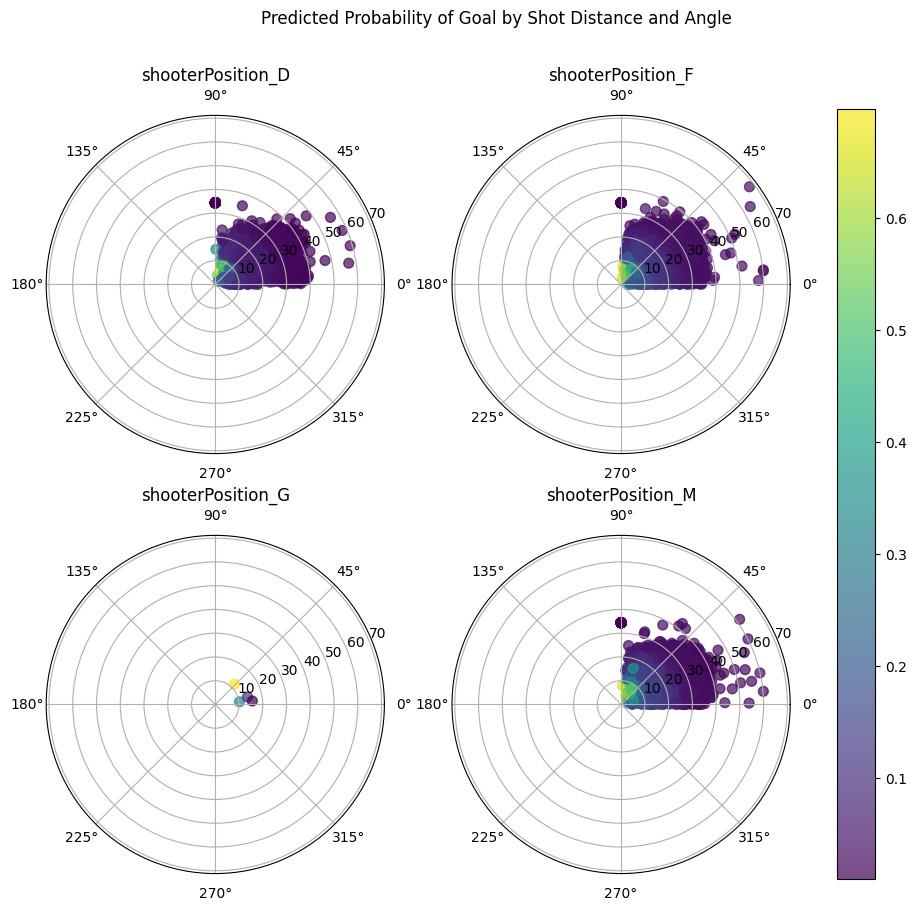

In [68]:
# plot inputs vs predictions
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(12, 10), subplot_kw={'projection': 'polar'}, sharex=True, sharey=True)
# unscale the features
X_test_unscaled = X_test.copy()
X_test_unscaled[['shotDistance', 'shotAngle', 'clockValue']] = scaler.inverse_transform(X_test[['shotDistance', 'shotAngle', 'clockValue']])
player_positions = [col for col in X.columns if 'shooterPosition_' in col]
# calculate radius and angle
r = X_test_unscaled['shotDistance']
theta = X_test_unscaled['shotAngle']
for i, ax in enumerate(axs.flatten()):
    idxs = X_test_unscaled[player_positions[i]] == 1
    ax.set_title(f'{player_positions[i]}')
    scatter = ax.scatter(theta[idxs], r[idxs], c=clf.predict_proba(X_test[idxs])[:, 1], cmap='viridis', s=50, alpha=0.7)
    if i == 0: fig.colorbar(scatter, ax=axs.ravel().tolist())

fig.suptitle('Predicted Probability of Goal by Shot Distance and Angle')
plt.show()
